In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd

# 0. Prepare Data

In [2]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG_myo")
from PrepareAndLoadData.process_data import read_data_training

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results_tsd"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results_tsd"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results_tsd"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=5, across_subjects=True)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (1, 3, 200, 572, 252)
traning labels  (1, 3, 200, 572)


In [6]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]               # #session
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

number_of_cycles_total  200


# 1. TSD_DNN

In [7]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_TSD_DNN_on_training_sessions, train_fine_tuning

In [9]:
train_fine_tuning(examples_datasets_train, labels_datasets_train,
                  num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
                  number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
                  batch_size=batch_size,
                  feature_vector_input_length=feature_vector_input_length,
                  learning_rate=learning_rate)

GET one participant_examples  (3, 200, 572, 252)
   GET one training_index_examples  (200, 572, 252)  at  0
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  1
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  2
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 0)
START TRAINING
Participant:  0
Session:  0
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connect

train Loss: 0.00498694 Acc: 0.77193136
val Loss: 0.00004464 Acc: 0.81931818
Epoch 7 of 500 took 5.366s
Epoch 7/499
----------
train Loss: 0.00488660 Acc: 0.7767996
val Loss: 0.00004233 Acc: 0.81809441
Epoch 8 of 500 took 5.492s
Epoch 8/499
----------
train Loss: 0.00486931 Acc: 0.77735347
val Loss: 0.00004055 Acc: 0.83190559
Epoch 9 of 500 took 5.325s
Epoch 9/499
----------
train Loss: 0.00477129 Acc: 0.78138604
val Loss: 0.00003832 Acc: 0.84213287
Epoch 10 of 500 took 5.321s
Epoch 10/499
----------
train Loss: 0.00473185 Acc: 0.78246463
val Loss: 0.00003756 Acc: 0.83968531
Epoch 11 of 500 took 5.312s
Epoch 11/499
----------
train Loss: 0.00468270 Acc: 0.78625428
val Loss: 0.00003833 Acc: 0.84012238
Epoch 12 of 500 took 5.414s

Training complete in 1m 5s
Best val loss: 0.000056
Session:  2
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum

In [9]:
algo_name = "standard_TSD"
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (3, 200, 572, 252)
   GET one training_index_examples  (200, 572, 252)  at  0
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  1
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  2
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_co

In [10]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0
Session_0,0.723531
Session_1,0.595979
Session_2,0.566189


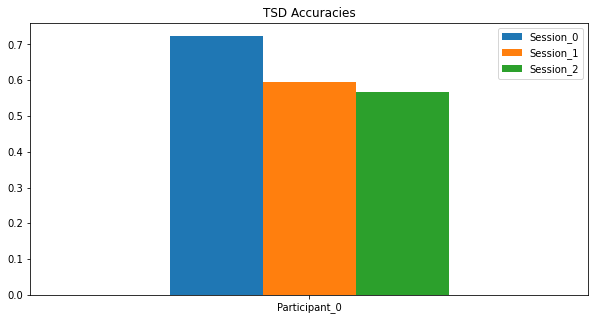

In [11]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

# 2. DANN

In [12]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [14]:
train_DANN(examples_datasets_train, labels_datasets_train, 
          num_kernels=num_kernels,
          path_weights_fine_tuning=path_TSD,
          number_of_classes=number_of_classes,
          number_of_cycles_total = number_of_cycles_total,
          batch_size=batch_size,
          feature_vector_input_length=feature_vector_input_length,
          path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

GET one participant_examples  (3, 200, 572, 252)
   GET one training_index_examples  (200, 572, 252)  at  0
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  1
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  2
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 0)
SHAPE SESSIONS:  (3,)
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_f

Accuracy source 0.795913, main loss classifier 0.353066, source classification loss 0.572805, loss domain distinction 0.172572, accuracy domain distinction 0.500000
VALIDATION Loss: 0.46750176 Acc: 0.82928322
Epoch 20 of 500 took 11.210s
Accuracy source 0.797128, main loss classifier 0.351925, source classification loss 0.570516, loss domain distinction 0.172598, accuracy domain distinction 0.500000
VALIDATION Loss: 0.48399287 Acc: 0.82237762
Epoch 21 of 500 took 11.160s
Accuracy source 0.797604, main loss classifier 0.351313, source classification loss 0.569310, loss domain distinction 0.172712, accuracy domain distinction 0.500000
VALIDATION Loss: 0.49146375 Acc: 0.81923077
Training complete in 4m 7s
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=

Accuracy source 0.796088, main loss classifier 0.351825, source classification loss 0.570606, loss domain distinction 0.172464, accuracy domain distinction 0.500000
VALIDATION Loss: 0.47083467 Acc: 0.8256993
Epoch 20 of 500 took 11.925s
Accuracy source 0.797973, main loss classifier 0.350785, source classification loss 0.568517, loss domain distinction 0.172563, accuracy domain distinction 0.500000
VALIDATION Loss: 0.47373542 Acc: 0.82963287
Epoch 21 of 500 took 12.034s
Accuracy source 0.796778, main loss classifier 0.351512, source classification loss 0.569997, loss domain distinction 0.172679, accuracy domain distinction 0.500000
VALIDATION Loss: 0.49127778 Acc: 0.82298951
Epoch 22 of 500 took 11.759s
Accuracy source 0.796399, main loss classifier 0.352259, source classification loss 0.571457, loss domain distinction 0.172687, accuracy domain distinction 0.500000
VALIDATION Loss: 0.48635092 Acc: 0.82473776
Epoch 23 of 500 took 11.534s
Accuracy source 0.798818, main loss classifier 0.

In [14]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (3, 200, 572, 252)
   GET one training_index_examples  (200, 572, 252)  at  0
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  1
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  2
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_co

In [15]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Participant_0
Session_0,0.723531
Session_1,0.671329
Session_2,0.649336


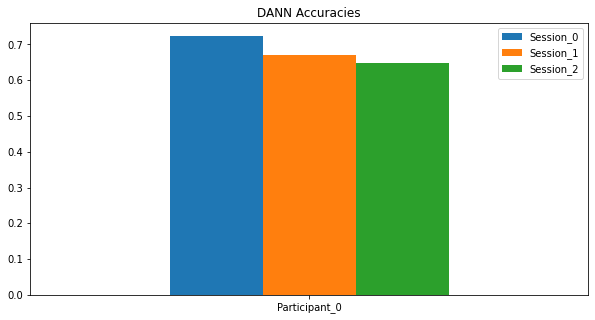

In [16]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

# 3. SCADANN

In [17]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SLADANN

In [20]:
percentage_same_gesture_stable = 0.75 
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
                              num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
                              path_weights_to_save_to=path_SCADANN,
                              path_weights_Adversarial_training=path_DANN,
                              path_weights_Normal_training=path_TSD,
                              number_of_cycles_total = number_of_cycles_total, 
                              number_of_classes=number_of_classes,
                              learning_rate=learning_rate)

GET one participant_examples  (3, 200, 572, 252)
   GET one training_index_examples  (200, 572, 252)  at  0
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (114400, 252)    (114400,)
   GET one training_index_examples  (200, 572, 252)  at  1
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (114400, 252)    (114400,)
   GET one training_index_examples  (200, 572, 252)  at  2
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (0,)    (0,)
       one group XY train (114400, 252)    (114400,)
dataloaders: 
   train  (1, 3)
   valid  (0,)
   test  (1, 0)
participants_train =  1
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReL

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.5384615384615384   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.23076923076923078   AFTER:  0.375  len before:  26   len after:  8
BEFORE:  0.38461538461538464   AFTER:  nan  len

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  15
BEFOR

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  11
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.6538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.15384615384615385   

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.

BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  0.5   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.8846153846153846  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.423076923076923

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8076923076923077   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  11
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  

BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7307692307692307   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.23076923076923078   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.15384615384615385   AFTER:  nan  len before:  26   len after: 

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.5384615384615384   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  1

BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER: 

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.7692307692307693   AFTER:  0.9230769230769231  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  11
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  1.0   AFTER:  1.0  l

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.5   AFTER:  0.4230769230769231  len before:  26

BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   

BEFORE:  0.6538461538461539   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5769230769230769   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  0.0   AFTER:  0.0  len before:  26 

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  0.7692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.2692307692307692  len before:  26

BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.5  len before:  26   len after:  6
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  0.4230769230769231   AFTER:  nan  len before:  26

BEFORE:  0.46153846153846156   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  11
BEFORE:  0.7692307692307693   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.38461538461538464   AFTER:  0.5  len before:  26   len after:  8
BEFORE:  0.69230769230769

STARTING TRAINING
Accuracy total 0.801792, main loss classifier 0.699935, source accuracy 0.771115 source classification loss 0.646744, target accuracy 0.832468 target loss 0.544627 accuracy domain distinction 0.500000 loss domain distinction 1.042495,
VALIDATION Loss: 0.39476036 Acc: 0.8822012
New best validation loss:  0.39476036430496875
Epoch 2 of 500 took 15.295s
Accuracy total 0.807433, main loss classifier 0.683016, source accuracy 0.772635 source classification loss 0.644058, target accuracy 0.842231 target loss 0.514598 accuracy domain distinction 0.500000 loss domain distinction 1.036880,
VALIDATION Loss: 0.32976302 Acc: 0.9026082
New best validation loss:  0.3297630210608353
Epoch 3 of 500 took 14.416s
Accuracy total 0.811016, main loss classifier 0.670430, source accuracy 0.773710 source classification loss 0.642683, target accuracy 0.848323 target loss 0.491302 accuracy domain distinction 0.500000 loss domain distinction 1.034368,
VALIDATION Loss: 0.43428405 Acc: 0.8629979

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.5384615384615384   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.23076923076923078   AFTER:  0.375  len before:  26   len after:  8
BEFORE:  0.38461538461538464   AFTER:  nan  len

BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  4
BEFORE:  0.3076923076923077   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  13
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  4
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  4
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6666666666666666  len before:  26   len after:  15
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0

BEFORE:  0.6538461538461539   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.11538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.26923076923076

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.9

BEFORE:  0.4230769230769231   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.19230769230769232   AFTER:  0.19230769230769232  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.

BEFORE:  0.15384615384615385   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.3333333333333333  len before:  26   len after:  9
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.42

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.23

BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  

BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.7307692307692307   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.5769230769230769   AFTER:  0.6  len before:  26   len after:  5
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.80

BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  14
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.23076923076923078  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.5384615384615

BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.6153846153846154   AFTER:  0.6923076923076923  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.8076

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.07692307692307693   AFTER:  0.0  l

BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  0.3076923076923077  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7307692307692307   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.7692307692307693   AFTER:  nan  len before:  26   len afte

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  4
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.7142857142857143  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.153

BEFORE:  0.11538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384 

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0 

BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.7  len before:  26   len after:  10
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.0  len before:  26   len after:  4
BEFORE:  0.9615384615384616   AFTER:  nan  len before:  

BEFORE:  0.6923076923076923   AFTER:  0.9615384615384616  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  2
BEFORE:  0.34615384615384615   AFTER:  0.34615384615384615  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  2

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.5   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.11538461538461539   AFTER:  nan  len before:  26 

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  13
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  4
BEFORE:  0.23076923076923078   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.269230769230769

BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.5769230769230769   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.7692307692307693   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  

BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.375  len before:  26   len after:  16
BEFORE:  0.8846153846153846   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.23076923076923078   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.15384615384615385   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.15384615384615385   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.0  len before:  2

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.884615384615384

BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   

BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.07692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  0.07692307692307693   AFTER:  0.0 

BEFORE:  0.46153846153846156   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.7692307692307693   AFTER:  0.8846153846153846  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.5   AFTER:  0.3  len before:  26   len after:  10
BEFORE:  0.6923076923076923   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.8461538461538461 

BEFORE:  0.8076923076923077   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232

VALIDATION Loss: 0.32821825 Acc: 0.90067901
New best validation loss:  0.3282182475361298
Epoch 14 of 500 took 13.212s
Accuracy total 0.826751, main loss classifier 0.639747, source accuracy 0.809675 source classification loss 0.571764, target accuracy 0.843827 target loss 0.501639 accuracy domain distinction 0.500000 loss domain distinction 1.030462,
VALIDATION Loss: 0.37978581 Acc: 0.87771605
Epoch 15 of 500 took 13.138s
Accuracy total 0.826797, main loss classifier 0.640005, source accuracy 0.810632 source classification loss 0.569805, target accuracy 0.842963 target loss 0.504125 accuracy domain distinction 0.500000 loss domain distinction 1.030406,
VALIDATION Loss: 0.31594700 Acc: 0.90888889
New best validation loss:  0.3159469957426777
Epoch 16 of 500 took 13.129s
Accuracy total 0.827592, main loss classifier 0.635040, source accuracy 0.809705 source classification loss 0.567763, target accuracy 0.845479 target loss 0.496358 accuracy domain distinction 0.500000 loss domain distin

VALIDATION Loss: 0.34307567 Acc: 0.90037037
Epoch 40 of 500 took 13.114s
Accuracy total 0.832989, main loss classifier 0.617772, source accuracy 0.812469 source classification loss 0.557714, target accuracy 0.853508 target loss 0.472247 accuracy domain distinction 0.500000 loss domain distinction 1.027922,
VALIDATION Loss: 0.33270780 Acc: 0.90061728
Epoch 41 of 500 took 13.131s
Accuracy total 0.832749, main loss classifier 0.618189, source accuracy 0.811898 source classification loss 0.557071, target accuracy 0.853601 target loss 0.473630 accuracy domain distinction 0.500000 loss domain distinction 1.028385,
VALIDATION Loss: 0.30754619 Acc: 0.90679012
Epoch 42 of 500 took 13.102s
Accuracy total 0.832209, main loss classifier 0.618604, source accuracy 0.813025 source classification loss 0.554980, target accuracy 0.851393 target loss 0.476640 accuracy domain distinction 0.500000 loss domain distinction 1.027939,
VALIDATION Loss: 0.32310029 Acc: 0.90395062
Epoch 43 of 500 took 13.155s
Acc

In [18]:
algo_name = "SCADANN"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (3, 200, 572, 252)
   GET one training_index_examples  (200, 572, 252)  at  0
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  1
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
   GET one training_index_examples  (200, 572, 252)  at  2
   GOT one group XY  (114400, 252)    (114400,)
       one group XY test  (28600, 252)    (28600, 252)
       one group XY train (102960, 252)    (102960,)
       one group XY valid (11440, 252)    (11440, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_co

In [19]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Participant_0
Session_0,0.723531
Session_1,0.700559
Session_2,0.659406


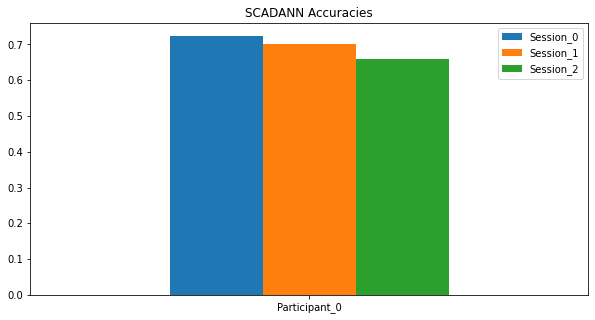

In [20]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

# Conclusion

In [21]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Participant_0
Session_0,0.723531
Session_1,0.595979
Session_2,0.566189


DANN


,Participant_0
Session_0,0.723531
Session_1,0.671329
Session_2,0.649336


SCADANN


,Participant_0
Session_0,0.723531
Session_1,0.700559
Session_2,0.659406


In [22]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.628566
DANN,0.681399
SCADANN,0.694499


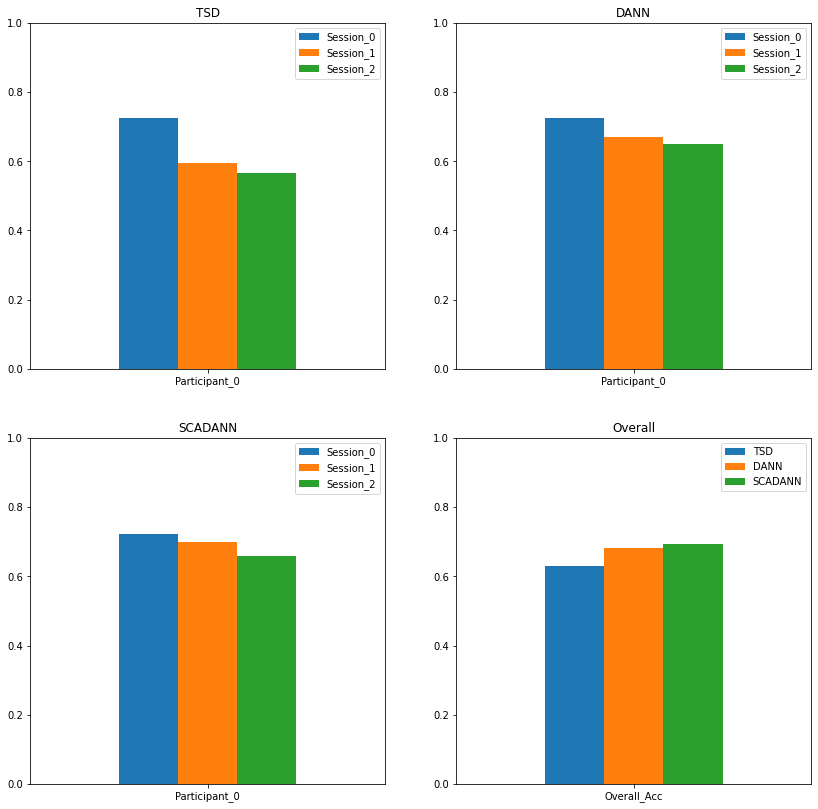

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])